---
title: "k-means"
format: html
---

This notebook uses data from the USGS Landsat 9 products. They are *not* distributed with the notebook because they are pretty large. We work from the `.dat` files that have been extracted from the raw data instead.

In [1]:
using Images
using CairoMakie
using Statistics
using DelimitedFiles
CairoMakie.activate!(; px_per_unit = 2)

The bands have been pre-processed, so we can load them directly:

In [2]:
R = readdlm("../data/kmeans/cooked/red.dat");
G = readdlm("../data/kmeans/cooked/green.dat");
B = readdlm("../data/kmeans/cooked/blue.dat");

This is enough to create a true color composite with the red, green, and blue channels:

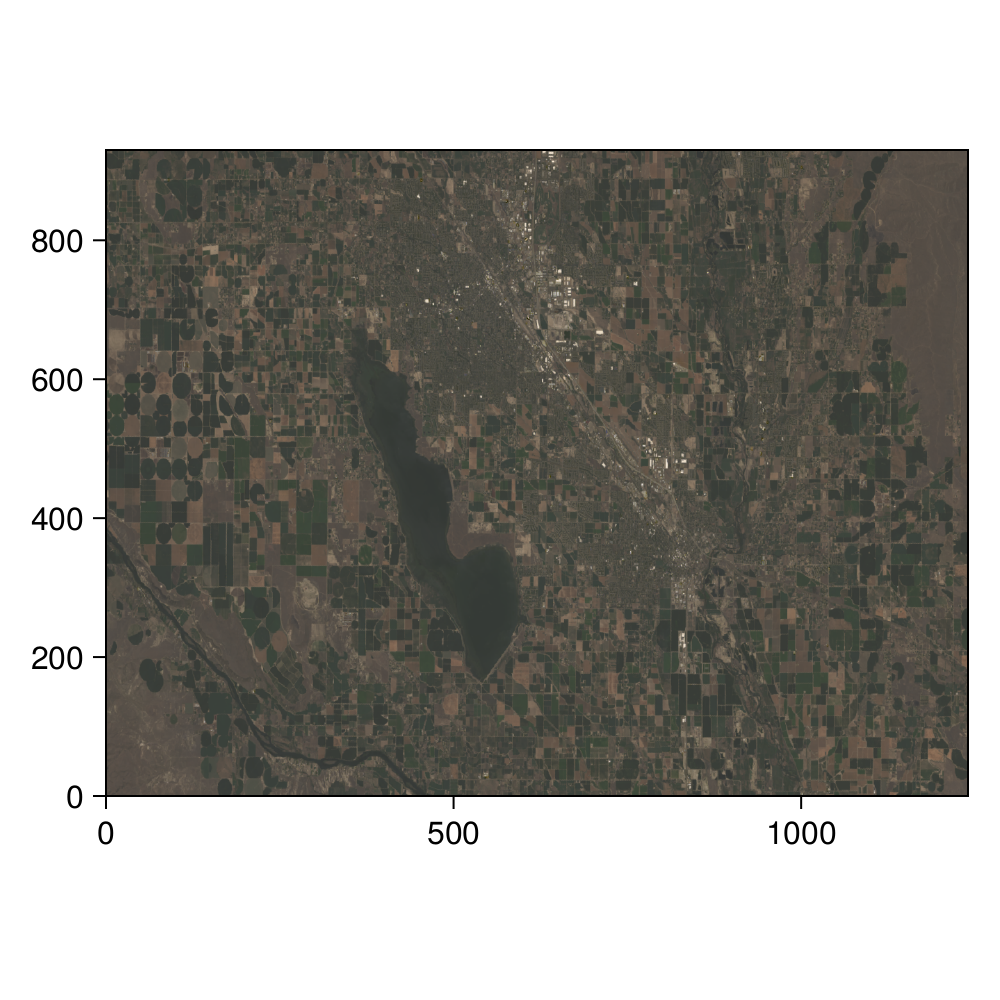

In [22]:
#| label: fig-visual
#| fig-cap: >
#|  The Landsat 9 data are combined into the "Natural Color" image, in which the red, green, and blue bands are mapped to their respective channels.
#|  This looks eerily like the way we perceive the landscape.
#|  Note how little difference there is between the large body of water and the surrounding crops.
#|  This emphasizes that the combination of channels we use will limit our ability to separate the pixels into groups.
cube = zeros(eltype(B), (3, size(B)...))
cube[1,:,:] .= R
cube[2,:,:] .= G
cube[3,:,:] .= B

tfile = tempname()*".png"
save(tfile, map(clamp01nan, colorview(RGB, cube.*2.75e-05)))

fig = Figure(resolution=(500, 500))
ax = Makie.Axis(fig[1,1], aspect=DataAspect())
image!(ax, load(assetpath(tfile)))
current_figure()

We also load the NIR and SWIR1 bands:

In [4]:
S = readdlm("../data/kmeans/cooked/swir.dat");
N = readdlm("../data/kmeans/cooked/nir.dat");

With these, we can do a vegetation fake color composite:

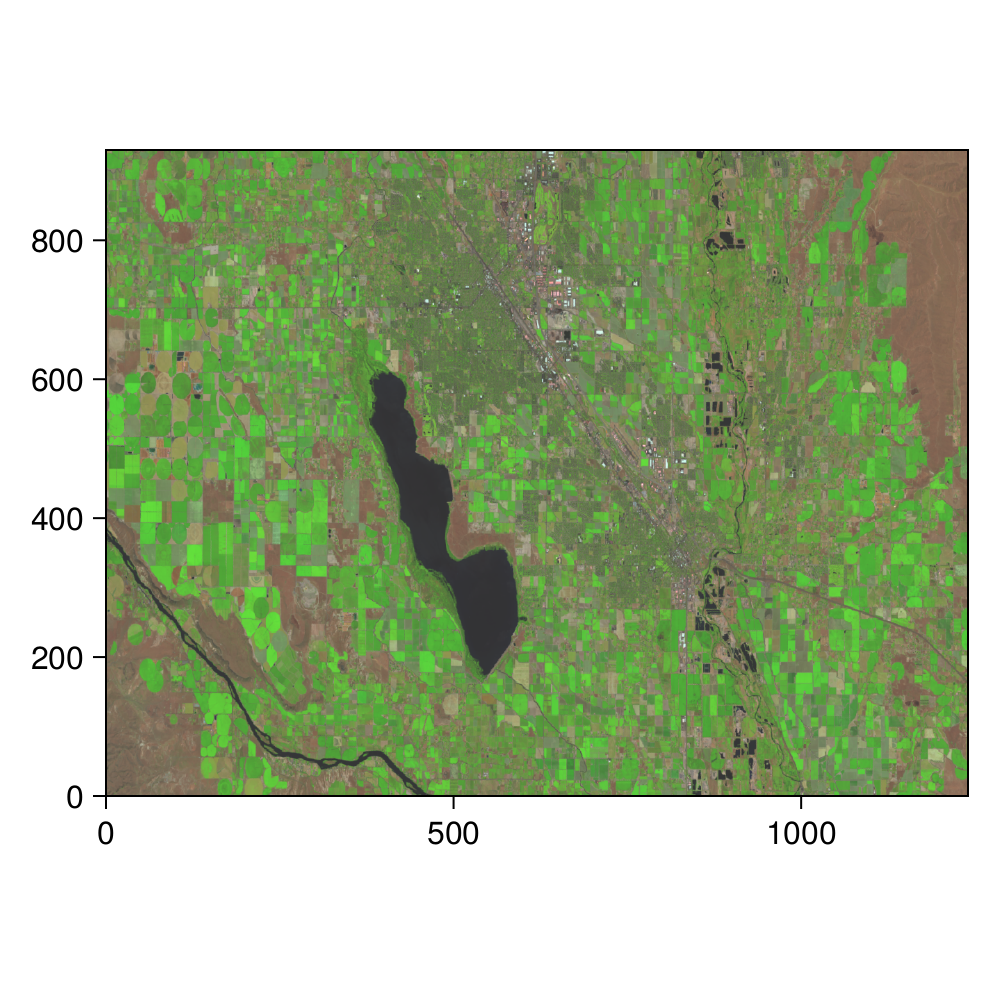

In [23]:
#| label: fig-color-veg
#| fig-cap: >
#|  The same landscape as above is now presented in a fake color composite, where SWIR is mapped to the red channel, NIR to the green channel, and red to the blue channel.
#|  This highlights different values in the landscape, but is no more or less "real" than the true color composite.
#|  It is a visualization of the data, that represents different choices, questions, and assumptions. 
#|  Compared to the Natural Color composite, this version of the data highlights the water, areas with vegetation, and more arid areas.
cube = zeros(eltype(B), (3, size(B)...))
cube[1,:,:] .= S
cube[2,:,:] .= N
cube[3,:,:] .= R

tfile = tempname()*".png"
save(tfile, map(clamp01nan, colorview(RGB, cube.*2.75e-05)))

fig = Figure(resolution=(500, 500))
ax = Makie.Axis(fig[1,1], aspect=DataAspect())
image!(ax, load(assetpath(tfile)))
current_figure()

We will not calculate the values of the NDVI, NDWI, and NDMI, which are normalized differences indices for respectively vegetation, water, and moisture:

In [24]:
ndvi = @. (N - R) / (N + R)
ndwi = @. (G - N) / (G + N)
ndmi = @. (N - S) / (N + S)

1240×930 Matrix{Float64}:
 -0.0582181  -0.0582181  -0.0647005  -0.0551127  …   0.0191553    0.0204363
 -0.0649106  -0.0649106  -0.0488467  -0.0466292      0.0151339    0.0199017
 -0.0638037  -0.0638037  -0.0282217  -0.0494436      0.0137433    0.0181219
 -0.0726644  -0.0726644  -0.0535822  -0.0487145      0.0126582    0.0150517
 -0.0804393  -0.0804393  -0.0743551  -0.0387745      0.0129138    0.0169332
 -0.0809717  -0.0809717  -0.0882701  -0.036612   …   0.0109481    0.0152403
 -0.0773282  -0.0773282  -0.0835949  -0.0626337      0.0158874    0.0223348
 -0.0577644  -0.0577644  -0.0715583  -0.0742989      0.00158983   0.000228363
 -0.0471664  -0.0471664  -0.0666667  -0.0941476      0.0419223    0.0128
 -0.0404455  -0.0404455  -0.0515807  -0.073478       0.23538      0.24148
  ⋮                                              ⋱               
 -0.119695   -0.110603   -0.109091   -0.103489      -0.112959    -0.109168
 -0.118046   -0.115458   -0.119087   -0.108284      -0.130255    -0.12142
 -

In [25]:
X = zeros(Float32, (3, prod(size(ndvi))...))
X[1,:] .= vec(ndvi)
X[2,:] .= vec(ndwi)
X[3,:] .= vec(ndmi)

1153200-element view(::Matrix{Float32}, 3, :) with eltype Float32:
 -0.058218077
 -0.06491063
 -0.06380368
 -0.07266436
 -0.0804393
 -0.08097166
 -0.07732823
 -0.05776444
 -0.047166362
 -0.040445488
  ⋮
 -0.109167844
 -0.12142039
 -0.1189251
 -0.11521253
 -0.11472213
 -0.10553586
 -0.111422956
 -0.114318706
 -0.11847795

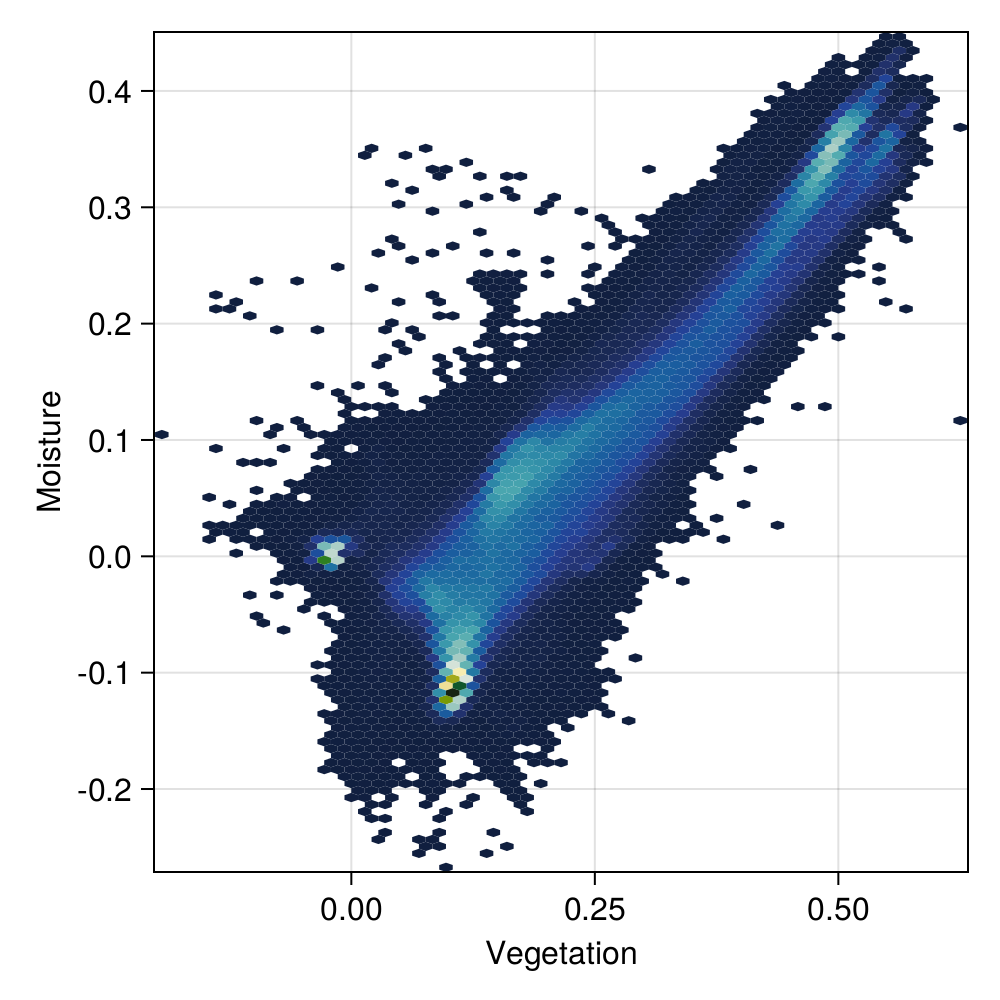

In [26]:
#| label: fig-hexbin
#| fig-cap: >
#|  The pixels acquired from Landsat 8 exist in a space with many different dimensions (one for each band).
#|  Because we are interested in a landscape classification based on water/vegetation data, we use the NDVI, NDMI, and NDWI 
#|  combinations of bands. These are *derived* data, and represent an instance of feature engineering: we have derived these values from the raw data.
fig = Figure(resolution=(500,500))
ax = Makie.Axis(fig[1,1]; xlabel="Vegetation", ylabel="Moisture")
hexbin!(ax, vec(ndvi), vec(ndmi), colormap=:delta, bins=120)
tightlimits!(ax)
current_figure()

We need a function for kmeans

In [27]:
using Clustering
clusters = kmeans(X, 5)

┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #36
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


KmeansResult{Matrix{Float32}, Float32, Int64}(Float32[0.20972064 0.4891362 … 0.111939415 0.34813344; -0.24096759 -0.45595855 … -0.15629296 -0.33944914; 0.06470381 0.3235208 … -0.0505223 0.17575169], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], Float32[6.6407025f-5, 0.00020799786, 0.00017768145, 0.0005780533, 0.0012579933, 0.0010600239, 0.0012652874, 0.0025329664, 0.002718605, 0.0026977658  …  0.0041742846, 0.0034545586, 0.0052726716, 0.004870847, 0.004253626, 0.004126191, 0.0030270293, 0.003731668, 0.004131891, 0.0047609136], [343952, 227148, 46024, 331102, 204974], [343952, 227148, 46024, 331102, 204974], 5089.9355f0, 57, true)

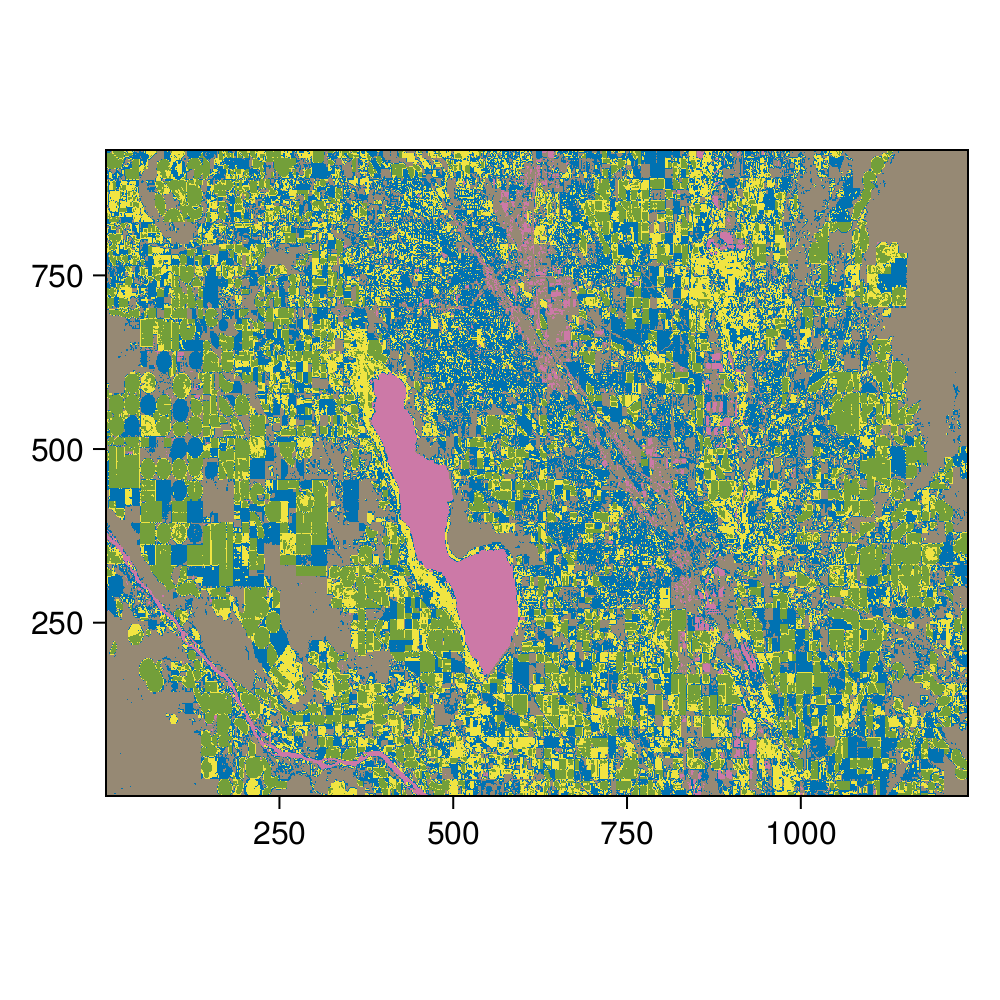

In [30]:
#| label: fig-classified-landscape
#| fig-cap: >
#|  After iterating the *k*-means algorithm, we obtain a classification for every pixel in the landscape.
#|  This classification is based on the values of NDVI, NDMI, and NDWI indices, and therefore groups pixels based on a specific hypothesis.
#|  This clustering was produced using $k=5$, *i.e.* we want to see what the landscape would look like when divided into five categories. 
C = reshape(assignments(clusters), size(ndvi))
fig = Figure(resolution=(500,500))
ax = Makie.Axis(fig[1,1]; aspect=DataAspect())
heatmap!(ax, C; colormap=Makie.wong_colors())
current_figure()

In [32]:
function DaviesBouldin(X, C)
    centroids = C.centers
    assigns = C.assignments
    S = zeros(Float64, size(centroids, 2))
    M = zeros(Float64, (size(centroids, 2), size(centroids, 2)))
    for i in unique(assigns)
        this_cluster = findall(isequal(i), assigns)
        centr = centroids[:,i]
        pts = X[:,this_cluster]
        S[i] = mean(sqrt.([sum((centr .- pts[:,j]).^2.0) for j in axes(pts, 2)]))
        for j in unique(assignments(clusters))
            if i >=j
                M[i,j] = M[j,i] = sqrt(sum((centroids[:,i] .- centroids[:,j]).^2.0))
            end
        end
    end

    R = (S .+ S')./M
    D = mapslices(v -> maximum(filter(!isinf, v)), R; dims=2)
    return sum(D)/length(unique(assigns))
end

DaviesBouldin(X, clusters)

0.6028450897524887

In [34]:
current_min = Inf
best_k = Inf
for k in repeat(3:7, 3)
    DB = DaviesBouldin(X, kmeans(X, k))
    if DB < current_min
        current_min = DB
        best_k = k
        @info "New optimum: $k -- $DB"
    end
end

┌ Warning: The clustering cost increased at iteration #21
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Info: New optimum: 3 -- 0.6348082594200207
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:8


┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Info: New optimum: 5 -- 0.602852164238117
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:8
┌ Warning: The clustering cost increased at iteration #24
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #85
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #94
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #23
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #36
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Info: New optimum: 4 -- 0.6023797971231126
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:8


┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #27
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #36
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #68
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #83
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #89
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #92
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #95
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #99
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #30
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #10
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #13
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #14
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #15
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #17
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #19
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #21
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #22
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #24
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #26
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #63
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #65
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #77
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #62
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #74
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #77
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #80
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #83
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #84
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #86
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #87
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #88
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #90
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #92
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #96
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #98
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #100
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


In [35]:
k = best_k
clusters = kmeans(X, k)
best_score = DaviesBouldin(X, clusters)
for i in 1:4
    tentative = kmeans(X, k)
    db = DaviesBouldin(X, tentative)
    if db < best_score
        clusters = tentative
        best_score = db
        @info "New optimum $db"
    end
end

┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #18
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #19
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #22
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #23
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #27
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Info: New optimum 0.6023799206644773
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:10
┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #30
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #23
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #27
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #36
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Info: New optimum 0.6023797971231126
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:10


┌ Warning: The clustering cost increased at iteration #26
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


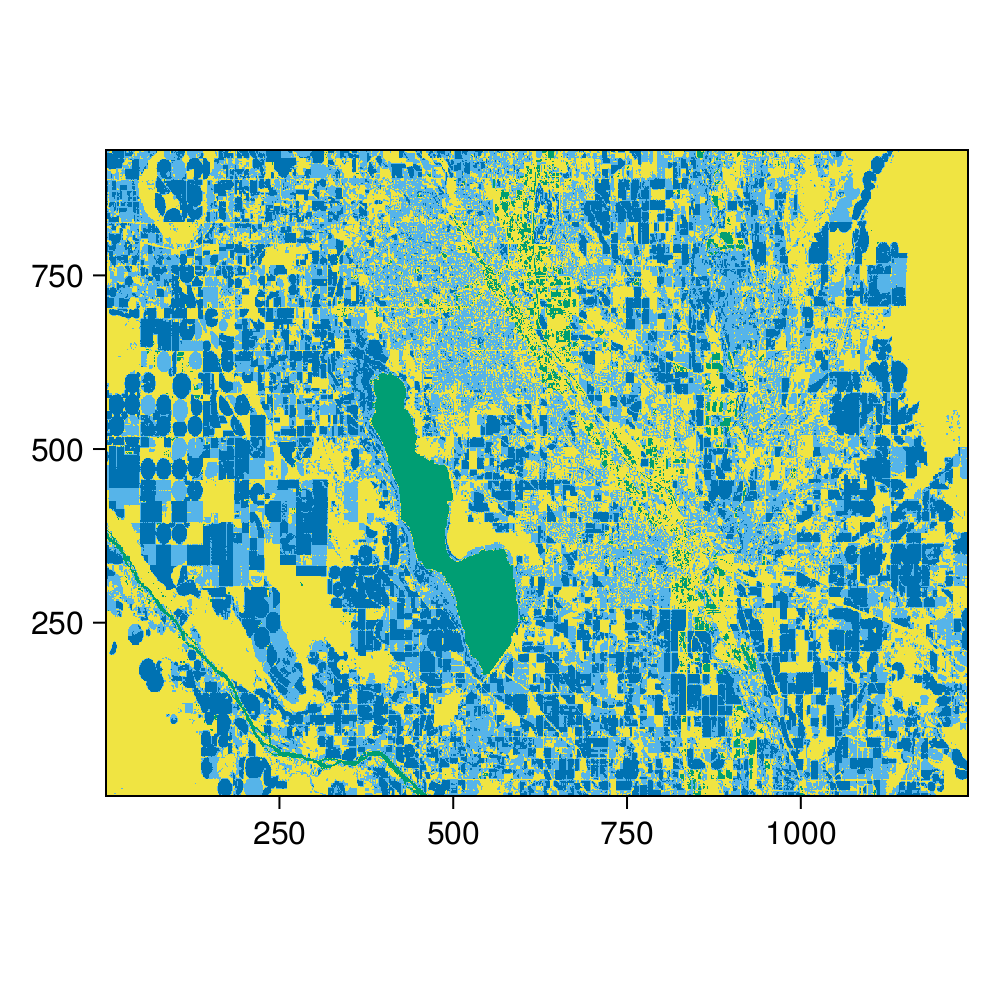

In [42]:
#| label: fig-optimal-landscape
#| fig-cap: >
#|  Classification of the landscape after picking the optimal value of the hyperparameter $k$,
#|  and by repeating the clustering process at this value of *k* several times.
#|  The optimal value, *i.e.* the one with the lowest Davies-Bouldin index, is presented.
#|  This solutions is *statistically* optimal, but there are very valid reasons to change the number of clusters manually in order to support
#|  the reason for which we run the analysis.
C = reshape(assignments(clusters), size(ndvi))
fig = Figure(resolution=(500,500))
ax = Makie.Axis(fig[1,1]; aspect=DataAspect())
heatmap!(ax, C; colormap=Makie.wong_colors())
current_figure()

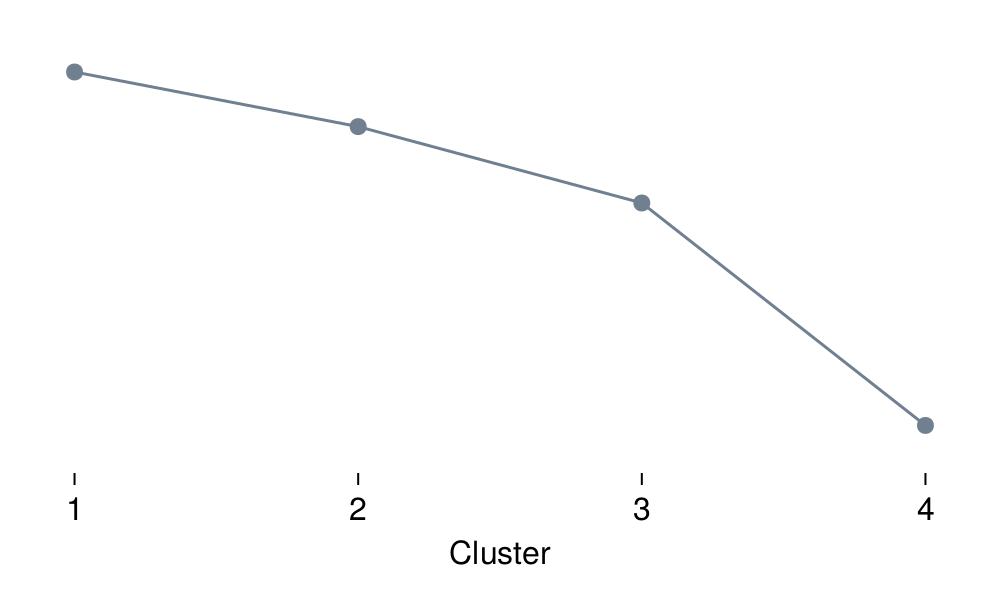

In [87]:
#| label: fig-barplot-classes
#| fig-cap: >
#|  Number of pixels assigned to each class in the final landscape classification.
#|  In most cases, *k*-means will create clusters with the same number of points in them.
#|  This may be an issue, or this may be a way to ensure that whatever classes are produced will be balanced in terms of their representation.
assigns = clusters.assignments
clust = unique(assigns)
counts = [count(isequal(k), assigns) for k in clust]

fig = Figure(resolution=(500,300))
ax = Makie.Axis(fig[1,1]; xlabel="Cluster", xgridvisible=false)
ylims!(ax, (0, maximum(counts)*1.1))
scatterlines!(ax, counts, color=:slategrey)
hidespines!(ax)
hideydecorations!(ax)
current_figure()